# 基于强化学习的交易策略

在本案例研究中，我们将创建一个基于强化学习（Reinforcement Learning）的端到端交易策略。

算法交易主要包括三个部分：策略制定、参数优化和回溯测试。策略根据当前的市场状态决定采取何种行动。参数优化是通过搜索策略参数的可能值（如阈值或系数）来实现的。最后，回溯测试通过利用历史数据探索交易策略的执行情况，评估交易策略的可行性。

强化学习（Reinforcement Learning）的基础是在给定的环境中制定出最大化回报的策略。RL 不需要手工编码基于规则的交易策略，而是直接学习策略。无需明确指定规则和阈值。它们自行决定政策的能力使 RL
模型非常适合用来创建自动算法交易模型或交易机器人的机器学习算法。

在参数优化和回溯测试步骤方面，RL 允许端到端优化，并最大化（可能延迟的）回报。强化学习代理是在模拟中训练出来的，其复杂程度可以随心所欲。考虑到延迟、流动性和费用，我们可以无缝结合回溯测试和参数优化步骤，而无需经过单独的阶段。

此外，RL 算法还能学习由人工神经网络参数化的强大策略。由于 RL 算法经过长期训练并具有足够的记忆力，它们还能通过历史数据来学习适应各种市场条件。这使得它们比基于监督学习的交易策略更能适应不断变化的市场，后者由于策略的简单性，可能没有足够强大的参数化来学习适应不断变化的市场条件。


强化学习能够轻松处理策略、参数优化和回溯测试，是下一波算法交易的理想选择。据传闻，大型投资银行和对冲基金的一些更复杂的算法执行部门似乎已开始使用强化学习来优化决策。

## 1. 问题定义

在本案例研究的强化学习框架中，算法会根据股价的当前状态采取相应的行动（买入、卖出或持有）。该算法使用深度 Q 学习模型进行训练，以执行最佳操作。本案例研究的强化学习框架的关键组成部分包括

基于强化学习（RL）的框架的主要组成部分是 ：

- 代理（Agent）： 交易代理。

- 行动（Action）： 买入、卖出或持有。

- 奖励函数（Reward function）： 本案例研究使用已实现损益（PnL）作为奖励函数。奖励取决于行动：

    - 卖出： 实现损益（卖出价 - 买入价）
    - 买入： 无奖励
    - 持有：无回报
- 状态（State）： 将给定时间窗口内过去股票价格的差异作为状态。
- 环境（Environment）：股票交易所

## 2. 加载数据


我们将使用的数据是标准普尔 500 指数的收盘价。数据摘自雅虎财经，包含从 2010 年到 2019 年的十年每日数据。

In [1]:
import pandas as pd
dataset = pd.read_csv('datasets/SP500.csv',index_col=0)
dataset

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000
...,...,...,...,...,...,...
2019-12-24,3225.449951,3226.429932,3220.510010,3223.379883,3223.379883,1296540000
2019-12-26,3227.199951,3240.080078,3227.199951,3239.909912,3239.909912,2160680000
2019-12-27,3247.229980,3247.929932,3234.370117,3240.020020,3240.020020,2428670000


## 3. 探索性数据分析

数据共有 2515 行和六列，包含开盘价、最高价、最低价、收盘价和调整后收盘价以及总成交量。调整后的收盘价是根据拆细和股息调整后的收盘价。在本案例研究中，我们将重点关注收盘价。

In [2]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,1962.147905,1971.346574,1952.200450,1962.608854,1962.608854,3.715246e+09
std,589.031496,590.190988,587.623893,588.910251,588.910251,8.134033e+08
min,1027.650024,1032.949951,1010.909973,1022.580017,1022.580017,1.025000e+09
25%,1381.642548,1390.700012,1372.800018,1384.404999,1384.404999,3.237625e+09
50%,1985.319946,1993.084961,1975.660034,1986.479981,1986.479981,3.587920e+09
75%,2434.179931,2441.522522,2427.959961,2433.967529,2433.967529,4.076530e+09
max,3247.229980,3247.929932,3234.370117,3240.020020,3240.020020,1.061781e+10


让我们看看股票走势图。

<Axes: title={'center': 'S&P500'}, xlabel='Date'>

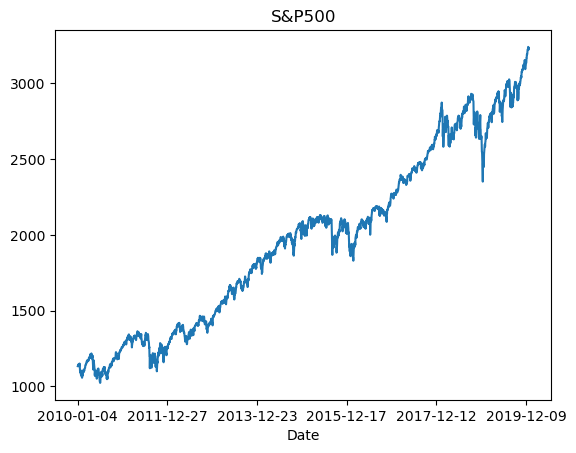

In [3]:
dataset['Close'].plot(title='S&P500')

## 4. 数据准备

### 数据清洗

让我们检查一下各行中的 空值（NA），要么删除它们，要么用列的平均值填满它们

In [4]:
print('Null Values =',dataset.isnull().values.any())

Null Values = False


如果出现空值，则用数据集中的最后一个值来填补缺失值。

In [5]:
dataset=dataset.fillna(method='ffill')
dataset.head(2)

/var/folders/sv/xyzb31jx2zz1ns_qr3d7hy700000gn/T/ipykernel_58088/1322760524.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset=dataset.fillna(method='ffill')


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.98999,1132.98999,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.52002,1136.52002,2491020000


聚类的参数是指数，聚类中使用的变量是列。因此，数据以正确的格式输入聚类算法

## 5. 模型和算法

### 5.1 训练集和测试集划分

我们将使用数据集的 80% 进行建模，使用 20% 进行测试。

In [6]:
X=list(dataset["Close"])
X=[float(x) for x in X]

如果数据不依赖于时间序列，则应根据顺序样本进行训练和测试拆分。
具体做法是在观测值的有序列表中任意选择一个分割点，然后创建两个新的数据集。

In [7]:
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]

### 5.2 模型实施

<img src='images/RL_trading.png' width=600>

简单来说，该算法就是在获得当前市场价格的情况下，决定是买入、卖出还是持有。该算法基于 "基于 Q 学习 "的方法，使用深度 Q 网络（DQN）来制定策略。如前所述，"Q-learning "这一名称来自 Q（s，a）函数，该函数根据状态 s 和提供的行动 a 返回预期奖励。

为了实现这种 DQN 算法，我们实现了多个函数和模块，它们在模型训练过程中相互影响。模块和函数概述如下。

- 代理类（Agent Class）： 代理被定义为 "代理 "类，该类包含变量和成员函数，用于执行我们之前讨论过的 Q 学习。代理 "类对象是在训练阶段创建的，用于训练模型。

- 帮助函数： 在这个模块中，我们创建了一些有助于训练的附加函数。我们有以下两个帮助函数。

- 训练模块： 在这一步中，我们使用变量、函数代理和助手方法对数据进行训练。这将根据一天结束时的股票价格状态，为我们提供三种操作之一（即买入、卖出或持有）。在训练过程中，我们会预测每天的规定动作，计算奖励，并在一系列事件中迭代更新基于深度学习的 Q-learning 模型权重。此外，每次行动的盈亏都会相加，以确定是否出现整体盈利。我们的目标是实现总利润最大化。我们将在下文的 "训练模型 "部分深入探讨不同模块和功能之间的相互作用。让我们详细了解每个模块

### 5.3 代理脚本

在本节中，我们将训练一个基于 Q-Learning 进行强化学习的代理。为此，我们将执行以下步骤：

- 创建一个代理类，其初始函数包含批量大小、状态大小和一个评估布尔函数，用于检查训练是否正在进行。
- 在代理类中，创建以下方法：
    - 构造函数： 构造器初始化所有参数。
    - 模型：该函数有一个深度学习模型，用于将状态映射到行动。
    - Act 函数：在给定状态下，使用模型函数的输出返回一个动作。行动的数量定义为 3：不操作、买、卖
    - expReplay：创建一个重放函数，用于添加、采样和评估缓冲区。在重放缓冲存储器中添加新的经验。从内存中随机抽取一批经验图元。在下面的函数中，我们从内存缓冲区中随机采样状态。经验重放存储了代理所经历的状态、行动、奖励和下一状态转换的历史。在代理选择ε-贪婪行动之前，它会从这些经验中随机抽取小批量样本，以便在每个时间步更新网络权重。
    
经验重放提高了样本效率，降低了在线学习过程中收集样本的自相关性，并限制了由于当前权重产生的训练样本可能导致局部最小值或发散的反馈。




In [9]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers.legacy import Adam
from IPython.core.debugger import set_trace

import numpy as np
import random
from collections import deque

class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        self.state_size = state_size # normalized previous days, 
        self.action_size = 3 # sit, buy, sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

        #self.model = load_model(model_name) if is_eval else self._model()

    #Deep Q Learning model- returns the q-value when given state as input 
    def _model(self):
        model = Sequential()
        #Input Layer
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        #Hidden Layers
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        #Output Layer 
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.001))
        return model
    
    #Return the action on the value function
    #With probability (1-$\epsilon$) choose the action which has the highest Q-value.
    #With probability ($\epsilon$) choose any action at random.
    #Intitially high epsilon-more random, later less
    #The trained agents were evaluated by different initial random condition
    #and an e-greedy policy with epsilon 0.05. This procedure is adopted to minimize the possibility of overfitting during evaluation.
 
    def act(self, state): 
        #If it is test and self.epsilon is still very high, once the epsilon become low, there are no random
        #actions suggested.
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)        
        options = self.model.predict(state)
        #set_trace()
        #action is based on the action that has the highest value from the q-value function.
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
        
        # the memory during the training phase. 
        for state, action, reward, next_state, done in mini_batch:
            target = reward # reward or Q at time t    
            #update the Q table based on Q table equation
            #set_trace()
            if not done:
                #set_trace()
                #max of the array of the predicted. 
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])     
                
            # Q-value of the state currently from the table    
            target_f = self.model.predict(state)
            # Update the output Q table for the given action in the table     
            target_f[0][action] = target
            #train and fit the model where state is X and target_f is Y, where the target is updated. 
            self.model.fit(state, target_f, epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

### 5.4 帮助函数

本节，我们将创建有助于培训的函数。我们将创建以下函数：

1. formatPrice:将价格格式化为小数点后两位，以减少数据的模糊性：

1. getStockData： 从 CSV 文件中返回股票数据向量。将数据中的股票收盘价转换为向量，并返回所有股票价格的向量。

1. getState：获取状态： 定义一个从输入向量生成状态的函数。从上一步创建的向量中生成状态，从而创建时间序列。该函数需要三个参数：数据、时间 t（要预测的那一天）和窗口（要回溯多少天）。然后将根据 sigmoid 函数测量这些向量之间的变化率。

In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt

# prints formatted price
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# # returns the vector containing stock data from a fixed file 
# def getStockData(key):
#     vec = []
#     lines = open("data/" + key + ".csv", "r").read().splitlines()

#     for line in lines[1:]:
#         vec.append(float(line.split(",")[4])) #Only Close column

#     return vec

# returns the sigmoid
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t

def getState(data, t, n):    
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    #block is which is the for [1283.27002, 1283.27002]
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

# Plots the behavior of the output
def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    #plt.savefig('output/'+name+'.png')
    plt.show()

### 5.5. 训练模型

<img src='images/Q-trading.png' width=600>

图：Q-trading的训练步骤

我们将根据代理和助手方法，对数据进行训练。这将根据一天结束时的股票价格状态，为我们提供三种操作之一。这些状态可以是买入、卖出或持有。在训练过程中，我们会预测每天的规定动作，并计算该动作的价格（盈利、亏损或不变）。在训练期结束时，将计算累计总和，我们将看到是盈利还是亏损。目的是使总利润最大化。

步骤：

1. 定义市场天数作为窗口大小，并定义训练神经网络的批量大小。

1. 使用窗口大小和批量大小实例化股票代理。

1. 使用辅助函数从 CSV 文件读取训练数据。

1. 集数已定义。代理将查看数据的次数。一集代表一次完整的数据遍历。

1. 我们可以开始遍历各集。

1. 每一集都必须根据数据和窗口大小以一种状态开始。在遍历数据之前，先初始化库存。

1. 开始迭代每天的股票数据。代理预测行动概率。

1. 接下来，对每一天的交易进行迭代，代理可以根据数据采取行动。代理每天都会决定一次行动。根据行动，代理将持有、卖出或买入股票。

1. 如果行动为 1，则代理买入股票。

1. 如果行动为 2，则代理卖出股票并从库存中删除。根据销售情况计算利润（或损失）。

1. 如果操作为 0，则没有交易。在此期间的状态可称为持有状态。

1. 状态、下一状态、操作等详细信息会保存在代理对象的内存中，并被 exeReply 函数进一步使用。

In [15]:
window_size = 1
agent = Agent(window_size)
l = len(dataset) - 1
batch_size = 10
states_sell = []
states_buy = []
episode_count = 3


for e in range(episode_count + 1):
    print("Running episode " + str(e) + "/" + str(episode_count))
    state = getState(dataset, 0, window_size + 1)
    #set_trace()
    total_profit = 0
    agent.inventory = []


    for t in range(l):
        action = agent.act(state)    
        # sit
        next_state = getState(dataset, t + 1, window_size + 1)
        reward = 0

        if action == 1: # buy
            agent.inventory.append(data[t])
            states_buy.append(t)
            print("Buy: " + formatPrice(data[t]))

        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)      
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)
            print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

        done = True if t == l - 1 else False
        next_state = getState(data, t + 1, window_size + 1)
        #appends the details of the state action etc in the memory, which is used further by the exeReply function
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
            #set_trace()
            #pd.DataFrame(np.array(agent.memory)).to_csv("Agent"+str(e)+".csv")
            #Chart to show how the model performs with the stock goin up and down for each 
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)    
            

    if e % 10 == 0:
        agent.model.save("model_ep" + str(e))

Running episode 0/3


KeyError: 0

In [ ]:
#Deep Q-Learning Model
print(agent.model.summary())

## 6. 测试数据

在对数据进行训练后，再根据测试数据集对其进行测试。我们的模型带来了总体利润。该模型最棒的一点是，随着时间的推移，利润不断提高，这表明它学习得很好，并采取了更好的行动。

In [26]:
#agent is already defined in the training set above.
test_data = X_test
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
is_eval = True
done = False
states_sell_test = []
states_buy_test = []
#Get the trained model
model_name = "model_ep"+str(episode_count)
agent = Agent(window_size, is_eval, model_name)
state = getState(data, 0, window_size + 1)
total_profit = 0
agent.inventory = []

OSError: No file or directory found at model_ep3

Buy: $2673.61
------------------------------------------
Total Profit: $3918.51
------------------------------------------
Buy: $2695.81
------------------------------------------
Total Profit: $3918.51
------------------------------------------
Buy: $2713.06
------------------------------------------
Total Profit: $3918.51
------------------------------------------
Sell: $2723.99 | profit: -$499.39
------------------------------------------
Total Profit: $3419.12
------------------------------------------
Buy: $2743.15
------------------------------------------
Total Profit: $3419.12
------------------------------------------
Buy: $2747.71
------------------------------------------
Total Profit: $3419.12
------------------------------------------
1/1 [==============================] - 0s 9ms/step
Sell: $2751.29 | profit: -$488.62
------------------------------------------
Total Profit: $2930.50
------------------------------------------
Buy: $2748.23
----------------------------------

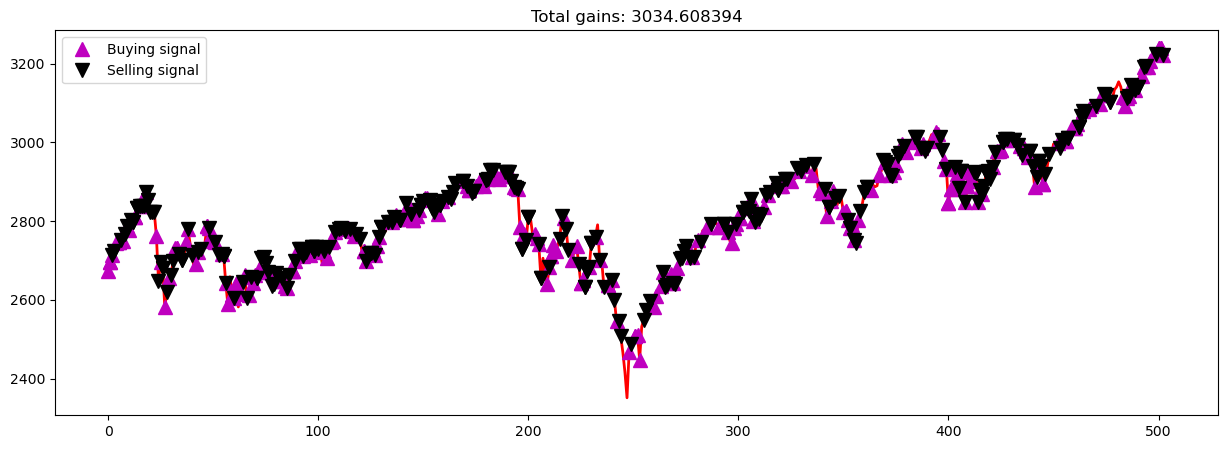

In [29]:
for t in range(l_test):
    action = agent.act(state)
    #print(action)
    #set_trace()
    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if action == 1:
        agent.inventory.append(test_data[t])
        states_buy_test.append(t)
        print("Buy: " + formatPrice(test_data[t]))

    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)
        #reward = test_data[t] - bought_price
        total_profit += test_data[t] - bought_price
        states_sell_test.append(t)
        print("Sell: " + formatPrice(test_data[t]) + " | profit: " + formatPrice(test_data[t] - bought_price))

    if t == l_test - 1:
        done = True
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print("------------------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        print("------------------------------------------")
        
plot_behavior(test_data,states_buy_test, states_sell_test, total_profit)

从上面的结果来看，我们的模型带来了 1280 美元的总体利润，可以说我们的 DQN 代理在测试集上的表现相当不错。不过，正如前面模型调整部分所讨论的那样，通过优化超参数，模型的性能还可以进一步提高。此外，鉴于模型的高复杂性和低可解释性，理想情况下，在将模型部署到实际交易之前，应该在不同时间段进行更多测试。

## 结论

据我们观察，我们无需决定交易策略或政策。算法自行决定策略，整体方法比基于监督学习的方法更简单、更有原则。

策略可以由复杂的模型（如深度神经网络）参数化，我们可以学习到比人类交易员的任何规则都更复杂、更强大的策略。

我们使用测试集对该模型进行了评估，发现测试集总体上是盈利的。